# 2 Matrix type A: compouse an expression matrix from raw-counts 
**Datatype are raw-count files like those produced with HTSeq-count**

Made by: Cynthia Soto <br>
Date: October 5th, 2020 <br>
Last md: May 18th, 2021 <br>

**Assumptions:** <br>
**Build Matrix type "A"** (integrate quantification file and remove zeros across samples) <br><br>
Data are gene quantification profiles from RNA-Seq libraries generated with STAR and HTSeq-count tools.<br>
Counting files (txt) need to be allocated in the same folder. <br>

1. Compouse an expr matrix from raw-count files <br>
2. Get some stats and distributions.  <br> 
3. Remove genes with common zeros across all samples.  <br>
4. Plot again.  <br>

In [1]:
# Libraries required
import os 
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Set some initial configuration 
pd.set_option("display.precision", 3)

In [2]:
# Set the directory to parse and the base_name of the dataset 
# notice all plots and files will use this base_name to label objects)

#  @dir_to_parse        Set the folder to be parse (the raw count must to be there)
#  @general_titles      This var is used to label the plots and save the main and temporary files. 

###   Here I am retrieving the infected datasets
dir_to_parse='athal3_htseq-counts/'
general_titles=" infected "

###   Here I am retrieving the control datasets
#dir_to_parse='athal1_htseq-counts/'
#general_titles=" healthy "

In [3]:
# Set the base directory
try:
    # Change the current working Directory      
    os.chdir("/home/cyntsc/Proyectos/tesis-code/meta-xtrome-analysis/"+dir_to_parse)
    print("Directory changed:", os.getcwd() )
except OSError:
    print("Can't change the Current Working Directory")        
#print(os.listdir(os.getcwd())  

Directory changed: /home/cyntsc/Proyectos/tesis-code/meta-xtrome-analysis/athal3_htseq-counts


### Declare functions 

In [4]:
# Rename (replace) the df columns to make them more intuitive for the visualizations (or whatever that you decide for the visualizations)

def set_ID_samples(df):
    df = df.rename(columns={'SRR10586397': 'Bc24', 'SRR364399':'Ch40.3','SRR364401':'Ch40',
                                         'SRR6283148':'Ss30','SRR6283147':'Ss30.1','SRR3383696':'Bc12',
                                         'SRR3383780':'Bc18','SRR6283146':'Ss30.2','SRR3383779':'Bc18.1',
                                         'SRR3383697':'Bc12.1','SRR364390':'Ch22','SRR364389':'Ch22.1',
                                         'SRR364400':'Ch40.1','SRR364391':'Ch22.2','SRR10586399':'Bc24.1',
                                         'SRR364392':'Ch22.3','SRR364398':'Ch40.2',
                                         'SRR3383821': 'healthy24', 'SRR3383783':'healthy18.1','SRR3383822':'healthy24.1',
                                         'SRR3383640':'healthy12','SRR3383641':'healthy12.1','SRR6283145':'healthy30.1',
                                         'SRR3383782':'healthy18','SRR6283144':'healthy30'})
    return df 

In [5]:
# Set ID index as "ID" to trigger the describe() function over a dataframe

def df_with_label_ID(df_stat):
    df_stat.reset_index(level=0, inplace=True)
    df_stat.rename(columns={'index': 'ID'}, inplace=True)
    
    ## use this chunk if you want to give IDs to a describe() functions from a external meta-data
    #     file='../meta-data/ID_samples.csv'
    #     df_meta=pd.read_csv(file, sep='\,', engine='python', usecols=[0,4]) 
    #     #print(df_meta.head(5))
    #     ## merge by sample field
    #     df = pd.merge(df, df_meta, on="sample")    
    df_stat = df_stat.sort_values(['ID'], ascending=[True])   
    return df_stat 

In [6]:
## Remove genes from a dataframe provided based on a list of indexes  

def df_drop_idx_list(df_idx, df_d):  #, df1_d

    ## @df_idx: list of gene idx to be removed
    ## @df_d: df provided 
    ## return the df with the idx list removed
    
    ## Get the indexes of the gene rows to delete from the df provided
    lst_genes_to_drop=(df_idx.index)
    ## drop the idx marked    
    for i in lst_genes_to_drop: 
        try:
            df_d = df_d.drop([i])
        except:
            pass # doing nothing on exception, not processed because it is already dropped"
    
    return df_d 

In [7]:
# Filter a dataframe by the value of the column (I used to set a cutoff threshold)

def filter_df(df, *args):

    ## @df: dataframe to be filtered
    ## @*args: the criteria to apply
    ## @df_cut: return a new dataframe filtered 
    
    for k, v in args:
        df_cut = df[df[k] >= v]
    return df_cut

In [8]:
# Plot a bar-chart as the result of the dataframe describe() function over an expression array (df)

def plot_intercuartile_bar(df, title, y_label):
    
    ## @df: a dataframe with the statistics generated with the describe()function 
    ## @title: text to be displayed as main-header in the plot
    ## @y_label: text to be displayed in the y axis label.
    
    ax = df.plot(x="ID", y="75%", kind="bar", figsize=(10,7))
    df.plot(x="ID", y="75%", kind="bar", ax=ax, color="C2")
    df.plot(x="ID", y="50%", kind="bar", ax=ax, color="C3")
    df.plot(x="ID", y="25%", kind="bar", ax=ax, color="C4")
    plt.title(title,fontsize=14);
    plt.xlabel('Sample ID',fontsize=14);
    plt.ylabel(y_label,fontsize=14);
    plt.xticks(rotation=45,fontsize=12);
    return

In [9]:
# Plot a line-chart with the mean and std.dev as the result of the dataframe describe() function over an expression array (df)

def plot_mean_sdev_line(df, title, y_label):
    
    ## @df: a dataframe with the statistics generated with the describe()function 
    ## @title: text to be displayed as main-header in the plot
    ## @y_label: text to be displayed in the y axis label.
  
    ## gca stands for 'get current axis'
    ax = plt.gca()
    df.plot(kind='line',x='ID',y='mean',color='green', ax=ax, figsize=(10,7))
    df.plot(kind='line',x='ID',y='std', color='red', ax=ax)
    plt.title(title,fontsize=14);
    plt.xlabel('Sample ID',fontsize=14);
    plt.ylabel(y_label,fontsize=14);
    plt.xticks(rotation=45,fontsize=12);
    return

### Integration of all data files (samples) in one matrix 

In [10]:
## check a bit of the files to be processed ... are they ok?
s_path = str(os.getcwd())+'/SRR*'  
all_files = glob.glob(s_path)
for file in all_files:
    print(file)

/home/cyntsc/Proyectos/tesis-code/meta-xtrome-analysis/athal3_htseq-counts/SRR6283147
/home/cyntsc/Proyectos/tesis-code/meta-xtrome-analysis/athal3_htseq-counts/SRR3383696
/home/cyntsc/Proyectos/tesis-code/meta-xtrome-analysis/athal3_htseq-counts/SRR364398
/home/cyntsc/Proyectos/tesis-code/meta-xtrome-analysis/athal3_htseq-counts/SRR364391
/home/cyntsc/Proyectos/tesis-code/meta-xtrome-analysis/athal3_htseq-counts/SRR364389
/home/cyntsc/Proyectos/tesis-code/meta-xtrome-analysis/athal3_htseq-counts/SRR364390
/home/cyntsc/Proyectos/tesis-code/meta-xtrome-analysis/athal3_htseq-counts/SRR6283146
/home/cyntsc/Proyectos/tesis-code/meta-xtrome-analysis/athal3_htseq-counts/SRR364392
/home/cyntsc/Proyectos/tesis-code/meta-xtrome-analysis/athal3_htseq-counts/SRR3383697
/home/cyntsc/Proyectos/tesis-code/meta-xtrome-analysis/athal3_htseq-counts/SRR10586399
/home/cyntsc/Proyectos/tesis-code/meta-xtrome-analysis/athal3_htseq-counts/SRR3383779
/home/cyntsc/Proyectos/tesis-code/meta-xtrome-analysis/ath

### Integrate raw count files into a single dataframe (matrix)

In [11]:
all_files = glob.glob(s_path)
## To load the main df
flag_b=True

for file in all_files:
    #print(file)
    # get the base name from a 'linux path' 
    sample = os.path.basename(file)

    if flag_b:    ## load main df once
        ## Main df is df1
        df1=pd.read_csv(file, sep='\t')    ## nrows=100, usecols=[0,1]
        df1.columns = ["Genes","Counts"]
        print(df1.head(3))
        ## remove lastest n rows refering to HTSeq stats (these are not counts)
        df1.drop(df1.tail(5).index,inplace=True) 
        ## remove unnamed cols
        df1.drop(df1.columns[df1.columns.str.contains('Unnamed',case=False)],axis=1,inplace=True)
        df1.rename(columns={'Counts':sample},inplace=True)
        #print(df1.head(3)) 
        flag_b=False
    else:
        #print(file)
        df2= pd.read_csv(file, sep='\t')    
        df2.columns = ["Genes","Counts"]
        ## remove lastest n rows refering to HTSeq stats (these are not counts)
        df2.drop(df2.tail(5).index,inplace=True) 
        ## remove unnamed cols
        df2.drop(df2.columns[df2.columns.str.contains('Unnamed',case=False)],axis=1,inplace=True)      
        ## compare matrix gene_names before concatenated
        comparison_column = np.where(df1["Genes"] == df2["Genes"], True, False)
        if (False in comparison_column):
            print("Gene_names are not the same. Matrix "+file+" will not be concatenated.")
        else:
            ## merge matrix based in column name "Genes"
            df2.rename(columns={'Counts':sample},inplace=True)
            df1=df1.merge(df2,on=['Genes'],how='left')
            

       Genes  Counts
0  AT1G01020      40
1  AT1G01030      33
2  AT1G01040      57


In [12]:
df1.head(5)

,Genes,SRR6283147,SRR3383696,SRR364398,SRR364391,SRR364389,SRR364390,SRR6283146,SRR364392,SRR3383697,SRR10586399,SRR3383779,SRR364399,SRR364400,SRR3383780,SRR10586397,SRR6283148,SRR364401
0,AT1G01020,40,141,123,184,160,176,38,199,165,140,120,105,123,168,149,34,127
1,AT1G01030,33,6,10,10,8,8,41,7,20,59,19,11,7,22,52,21,13
2,AT1G01040,57,1057,631,1063,917,856,106,1082,1334,1176,898,613,613,1218,1149,74,647
3,AT1G01050,18,1246,258,426,437,412,50,465,1608,857,714,247,313,871,1000,25,284
4,AT1G01060,3,798,488,377,176,164,1,353,1058,136,10960,517,474,13574,102,2,525


In [13]:
# call a function to set label sample's as IDs
df1 = set_ID_samples(df1)
df1.head(3)

,Genes,Ss30.1,Bc12,Ch40.2,Ch22.2,Ch22.1,Ch22,Ss30.2,Ch22.3,Bc12.1,Bc24.1,Bc18.1,Ch40.3,Ch40.1,Bc18,Bc24,Ss30,Ch40
0,AT1G01020,40,141,123,184,160,176,38,199,165,140,120,105,123,168,149,34,127
1,AT1G01030,33,6,10,10,8,8,41,7,20,59,19,11,7,22,52,21,13
2,AT1G01040,57,1057,631,1063,917,856,106,1082,1334,1176,898,613,613,1218,1149,74,647


## Some initial stats 

1) Descriptive stats are calculate on the new df<br>
2) IDs of genes with cero counts across all the samples are identified and summarized.<br>
3) IDs identified are dropped from the the df to compose a new df filtered. <br>

In [14]:
df_plot=df1.describe().T
df_plot.head(5)

,count,mean,std,min,25%,50%,75%,max
Ss30.1,27654.0,220.027,1785.209,0.0,0.0,3.0,50.00,113794.0
Bc12,27654.0,399.494,2197.593,0.0,0.0,57.0,315.00,196583.0
Ch40.2,27654.0,315.562,1396.964,0.0,0.0,38.0,229.00,71578.0
Ch22.2,27654.0,328.425,1368.659,0.0,0.0,59.0,299.00,111911.0
Ch22.1,27654.0,329.295,1504.571,0.0,0.0,55.0,290.75,151388.0


In [15]:
## call the fuction df_with_label_ID
df_plot = df_with_label_ID(df_plot)
df_plot.head(5)

,ID,count,mean,std,min,25%,50%,75%,max
1,Bc12,27654.0,399.494,2197.593,0.0,0.0,57.0,315.0,196583.0
8,Bc12.1,27654.0,494.320,2870.421,0.0,0.0,68.0,375.0,257238.0
13,Bc18,27654.0,416.255,1962.741,0.0,0.0,55.0,335.0,165685.0
10,Bc18.1,27654.0,312.448,1682.586,0.0,0.0,42.0,238.0,162222.0
14,Bc24,27654.0,662.250,2641.587,0.0,2.0,110.0,551.0,180982.0


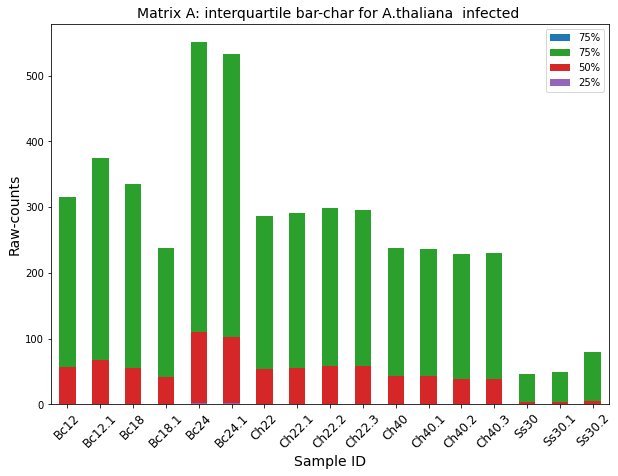

In [16]:
plot_intercuartile_bar(df_plot, 'Matrix A: interquartile bar-char for A.thaliana '+ general_titles, 'Raw-counts')

/home/cyntsc/Proyectos/tesis-code/jn_tesis_env/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


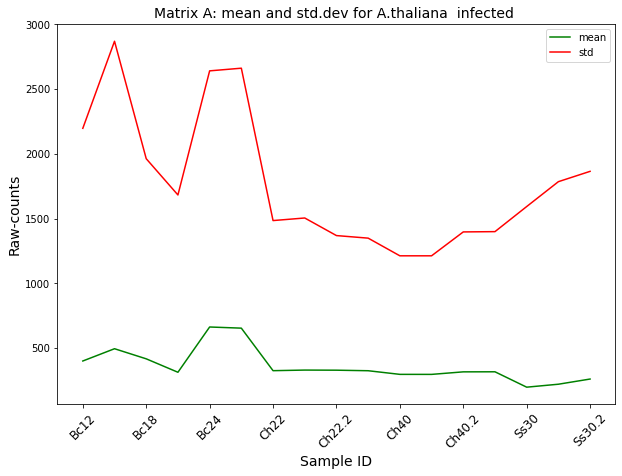

In [17]:
plot_mean_sdev_line(df_plot, 'Matrix A: mean and std.dev for A.thaliana '+ general_titles,'Raw-counts' )

## Check for genes with zeros across all samples

In [20]:
df1.head(5)

,Genes,Ss30.1,Bc12,Ch40.2,Ch22.2,Ch22.1,Ch22,Ss30.2,Ch22.3,Bc12.1,Bc24.1,Bc18.1,Ch40.3,Ch40.1,Bc18,Bc24,Ss30,Ch40
0,AT1G01020,40,141,123,184,160,176,38,199,165,140,120,105,123,168,149,34,127
1,AT1G01030,33,6,10,10,8,8,41,7,20,59,19,11,7,22,52,21,13
2,AT1G01040,57,1057,631,1063,917,856,106,1082,1334,1176,898,613,613,1218,1149,74,647
3,AT1G01050,18,1246,258,426,437,412,50,465,1608,857,714,247,313,871,1000,25,284
4,AT1G01060,3,798,488,377,176,164,1,353,1058,136,10960,517,474,13574,102,2,525


In [21]:
## Check number of zeros by sample
sr_ceros = df1.isin([0]).sum()
type(sr_ceros)
## transform the pandas serie into a pandas df
df_ceros = sr_ceros.to_frame()
## format the df (idx)
df_ceros.columns = df_ceros.iloc[0]
df_ceros = df_ceros.drop(df_ceros.index[0])
#df_ceros.head()
## call a function to set ID labels 
df_ceros = df_with_label_ID(df_ceros)
#df_ceros.to_csv("../results-data/tmp/matrix_A_zerosBysample_"+ general_titles.strip() +".csv", index=False, header=True)


Genes,ID,0
1,Bc12,7518
8,Bc12.1,7375
13,Bc18,7549
10,Bc18.1,7719
14,Bc24,5627
9,Bc24.1,5703
5,Ch22,7229
4,Ch22.1,7164
3,Ch22.2,7185
7,Ch22.3,7219


In [22]:
df_ceros

Genes,ID,0
1,Bc12,7518
8,Bc12.1,7375
13,Bc18,7549
10,Bc18.1,7719
14,Bc24,5627
9,Bc24.1,5703
5,Ch22,7229
4,Ch22.1,7164
3,Ch22.2,7185
7,Ch22.3,7219


***Here, zeros are counted by genes across all samples & a new column with the zero-counter values is appended to the matrix*** <br>
We're going to create the file called: **all_healthy_counterOFzeros.csv** contains the counter of zeros by gene <br>

In [22]:
s_zeros = (df1 == 0).astype(int).sum(axis=1)
#print(s_zeros)
#type(s_zeros)    ### build a serie-pandas
## Desglozando la formula
#(df1 == 0)
#(df1 == 0).astype(int)
#(df1 == 0).sum(axis=1)

## Added a column to df1 with the counter of zeros
df1['zero-counter'] = s_zeros
df1.head(3)

,Genes,healthy30.1,healthy30,healthy12,healthy18.1,healthy18,healthy24.1,healthy12.1,healthy24,zero-counter
0,AT1G01020,175,163,108,117,224,92,267,145,0
1,AT1G01030,20,25,13,13,35,16,22,9,0
2,AT1G01040,2541,2492,1027,1324,2376,638,2296,1018,0


In [23]:
general_titles.strip()

'healthy'

Here, we look for genes with n number of ceros <br>
A file called: **matrix_A_zero_counter_Bysample_[infected/healthy]** contains the detail of these counts

In [24]:
i_samples = (len(df1.columns)-2)

In [25]:
is_zero = (df1['zero-counter']>=i_samples)  
df_zero = df1[is_zero]

In [26]:
print(df_zero.shape)
df_zero.head(7)

(5228, 10)


,Genes,healthy30.1,healthy30,healthy12,healthy18.1,healthy18,healthy24.1,healthy12.1,healthy24,zero-counter
26,AT1G01280,0,0,0,0,0,0,0,0,8
29,AT1G01305,0,0,0,0,0,0,0,0,8
32,AT1G01335,0,0,0,0,0,0,0,0,8
40,AT1G01400,0,0,0,0,0,0,0,0,8
41,AT1G01410,0,0,0,0,0,0,0,0,8
47,AT1G01460,0,0,0,0,0,0,0,0,8
99,AT1G01980,0,0,0,0,0,0,0,0,8


In [27]:
## save the result in the tmp/ folder
df_zero.to_csv("../results-data/tmp/matrix_A_zero_counter_Bysample_"+ general_titles.strip()+".csv", sep='\t', index=False)

In [28]:
# ## Filter is looking for genes with 8 zeros across all samples in the healthy df (we have 8 samples for control)
# ##                   and genes with 17 zeros across all samples in the infected df (we have 17 samples infected)

# if general_titles.strip() == 'healthy':
#     is_zero = (df1['zero-counter']>=8)     
#     df_zero = df1[is_zero]
#     df_zero.to_csv("../results-data/tmp/matrix_A_zero-counterBysample_"+ general_titles.strip()+".csv", sep='\t', index=False)
# else:
#     is_zero = (df1['zero-counter']>=17)     
#     df_zero = df1[is_zero]
#     df_zero.to_csv("../results-data/tmp/all_"+ general_titles.strip() +"_genes_w17zeros.csv", sep='\t', index=False)
# print(df_zero.shape)
# df_zero.head(7)
# ## save the result in the tmp/ folder

In [29]:
## Here, we count how many genes are not expressed in all the samples
df1.isin([0]).sum().head()

Genes             0
healthy30.1    7688
healthy30      7700
healthy12      7396
healthy18.1    7627
dtype: int64

In [30]:
# call the function  ==== df_drop_idx_list ==== to get the index of the genes to remove (df1_17) from the df1
df1 = df_drop_idx_list(df_zero, df1)

In [31]:
print(df1.shape)
df1.head(5)

(22426, 10)


,Genes,healthy30.1,healthy30,healthy12,healthy18.1,healthy18,healthy24.1,healthy12.1,healthy24,zero-counter
0,AT1G01020,175,163,108,117,224,92,267,145,0
1,AT1G01030,20,25,13,13,35,16,22,9,0
2,AT1G01040,2541,2492,1027,1324,2376,638,2296,1018,0
3,AT1G01050,1531,1804,850,1217,2664,406,1851,684,0
4,AT1G01060,11,4,288,18184,32522,219,835,386,0


In [32]:
df1.to_csv("../results-data/matrix_A_"+general_titles.strip()+".csv", sep='\t', index=False)

## Create new stats over matrix A

In [33]:
## Save the matrix A: genes for Athal infected in common across samples removed (17 samples)
##                    genes for Athal healthy in common across samples removed. (8 samples)

In [35]:
## Gets some stats on the new filtered array of genes with common zeros
df_tmp = df1.describe().T
df_tmp.drop(df_tmp.tail(1).index,inplace=True) # drop last n rows / or first n rows (.head)
df_tmp 

,count,mean,std,min,25%,50%,75%,max
healthy30.1,22426.0,780.161,3262.507,0.0,12.0,174.0,644.00,141108.0
healthy30,22426.0,871.275,4507.605,0.0,11.0,159.0,638.00,274644.0
healthy12,22426.0,428.724,2057.596,0.0,12.0,109.0,366.00,153437.0
healthy18.1,22426.0,558.032,3572.027,0.0,11.0,113.0,398.00,315702.0
healthy18,22426.0,1176.774,7908.412,0.0,24.0,227.0,805.75,660692.0
healthy24.1,22426.0,393.805,2260.049,0.0,9.0,88.0,292.00,113771.0
healthy12.1,22426.0,883.375,4162.506,0.0,21.0,230.0,774.00,315017.0
healthy24,22426.0,594.077,2925.914,0.0,13.0,137.0,463.75,148426.0


In [36]:
## call a function to set ID to the accesions
df_tmp = df_with_label_ID(df_tmp)
df_tmp.head(5)

,ID,count,mean,std,min,25%,50%,75%,max
2,healthy12,22426.0,428.724,2057.596,0.0,12.0,109.0,366.00,153437.0
6,healthy12.1,22426.0,883.375,4162.506,0.0,21.0,230.0,774.00,315017.0
4,healthy18,22426.0,1176.774,7908.412,0.0,24.0,227.0,805.75,660692.0
3,healthy18.1,22426.0,558.032,3572.027,0.0,11.0,113.0,398.00,315702.0
7,healthy24,22426.0,594.077,2925.914,0.0,13.0,137.0,463.75,148426.0


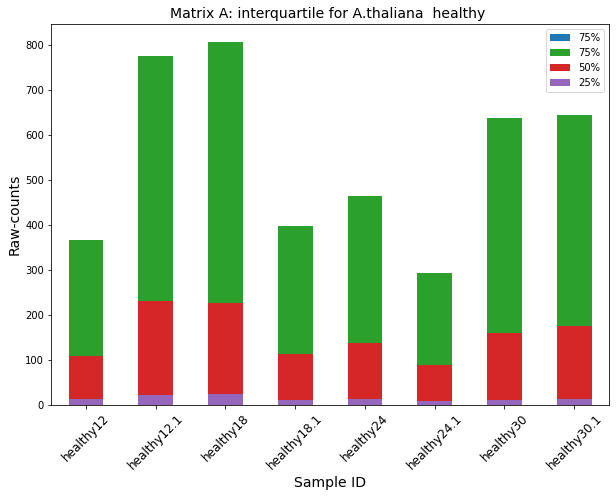

In [38]:
# Plot and save stats for the matrix type A
plot_intercuartile_bar(df_tmp, 'Matrix A: interquartile for A.thaliana '+ general_titles,'Raw-counts')
df_tmp.to_csv("../results-data/statistics/matrix_A_stats_"+ general_titles.strip()+".csv", index=False, header=True)

/home/cyntsc/Proyectos/tesis-code/jn_tesis_env/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


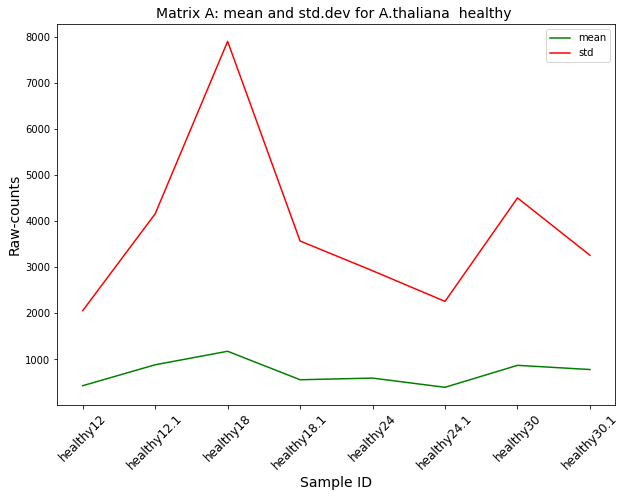

In [39]:
plot_mean_sdev_line(df_tmp,'Matrix A: mean and std.dev for A.thaliana '+ general_titles,'Raw-counts')

In [41]:
col_ceros = df_tmp['std'].tolist()
col_ceros.sort(reverse=False)
print(col_ceros)

[2057.595729784199, 2260.0490396581363, 2925.913597762728, 3262.5071812483015, 3572.026812657692, 4162.506472369159, 4507.605488541885, 7908.412461073177]


## Now explore the new distributions with zeros in common removed across all samples
Plot all the sample in one plot (histogram and KDE)

In [42]:
# load file to be plotted

#print(os.getcwd())
df_nozeros = pd.read_csv("../results-data/matrix_A_"+general_titles.strip()+".csv", sep='\t')  
# dropping not-useful columns 
df_nozeros.drop(["Genes", "zero-counter"], axis = 1, inplace = True) 
print(df_nozeros.head(3))

   healthy30.1  healthy30  healthy12  healthy18.1  healthy18  healthy24.1  \
0          175        163        108          117        224           92   
1           20         25         13           13         35           16   
2         2541       2492       1027         1324       2376          638   

   healthy12.1  healthy24  
0          267        145  
1           22          9  
2         2296       1018  


Plot both the histogram and densities in the same plot with the seaborn package (imported as sns) which allows you to do that via the distplot(). 
Since seaborn is built on top of matplotlib, you can use the sns and plt one after the other.

In [43]:
## Get sample list names
sample_lst=df_nozeros.columns
print(sample_lst)
df_nozeros.head(5)

Index(['healthy30.1', 'healthy30', 'healthy12', 'healthy18.1', 'healthy18',
       'healthy24.1', 'healthy12.1', 'healthy24'],
      dtype='object')


,healthy30.1,healthy30,healthy12,healthy18.1,healthy18,healthy24.1,healthy12.1,healthy24
0,175,163,108,117,224,92,267,145
1,20,25,13,13,35,16,22,9
2,2541,2492,1027,1324,2376,638,2296,1018
3,1531,1804,850,1217,2664,406,1851,684
4,11,4,288,18184,32522,219,835,386


[20, 2541, 1531, 11, 39, 1280, 5079, 1458, 8]
[25, 2492, 1804, 4, 106, 1131, 6032, 1088, 31]
[13, 1027, 850, 288, 42, 975, 1281, 483, 10]
[13, 1324, 1217, 18184, 172, 981, 1799, 503, 10]
[35, 2376, 2664, 32522, 311, 2124, 3912, 1319, 22]
[16, 638, 406, 219, 61, 429, 962, 399, 14]
[22, 2296, 1851, 835, 80, 1927, 2801, 1060, 10]
[9, 1018, 684, 386, 216, 494, 1371, 581, 22]


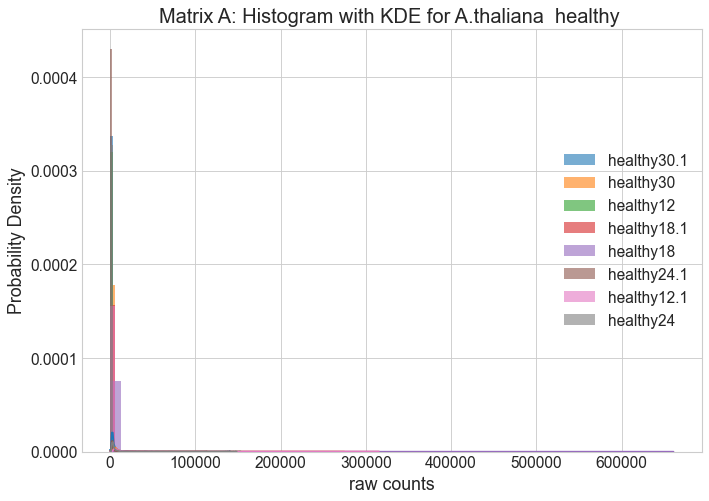

In [44]:
# Plot the distributions of the matrix type A

plt.style.use('seaborn-whitegrid')
kwargs=dict(hist_kws={"alpha":0.6, "lw": 2})
plt.rc('xtick',labelsize=14)
plt.rc('ytick',labelsize=14)

plt.figure(figsize=(10,7), dpi= 80)
for file in sample_lst:
    sample_data = df_nozeros[file].tolist()
    print(sample_data[1:10])
    #sns.distplot(sample_data, label=ID_sample+' hpi', **kwargs)   #color="dodgerblue", 
    sns.distplot(sample_data, label=file, **kwargs)   #color="dodgerblue", 

plt.title('Matrix A: Histogram with KDE for A.thaliana '+ general_titles,fontsize=18);
plt.xlabel('raw counts',fontsize=16);
plt.ylabel('Probability Density', fontsize=16);

## add arbitrary lines to canvas
#plt.plot([0, 15], [.15, .15], 'k-', lw=2, color='blue',marker = 'o')
#plt.plot([0, 15], [.74, .74], 'k-', lw=2, color='red',marker = '*')
plt.legend(loc='center right',fontsize=14);    
#plt.savefig("../plots/all_infected_KDE_17zeros_drop.png");